# Compile usage analytics from a booking calendar

Plot usage stats by user for the year

Usage: 
- Set the list of files and the starting date and run the notebook
- Check if there are no unknown group for the user, edit the users.csv file to update it if needed and run again the notebook. 

In [15]:
import glob
start_date = '2020-11-02' # iso-format data yyyy-mm-dd
num_weeks = 52
file_list = glob.glob('*.xlsx')
users_file = 'users.csv'
groups_file = 'groups.csv'
booking_types = ['service', 'maintenance', 'training']
remove_bookings_type = ['service', 'maintenance']
remove_instrument = ['Analysis PC 1','Analysis PC 2' ,'Analysis PC 3' ,'Analysis PC 4','SIM Analysis PC']

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import os.path

def load_ics(filename,type_list):
    """Load data from an ics calendar file"""
    from ics import Calendar
    c = Calendar(open(filename).read())
    ev = [e for e in c.events if e.organizer is not None]
    d = {'User': [e.organizer.common_name for e in ev],
         'Start': [e.begin.datetime for e in ev],
         'End': [e.end.datetime for e in ev],
         'Subject':[e.end.datetime for e in ev]
    }
    bookings['Duration'] = bookings['End'] - bookings['Start']
    bookings['Hours'] = [x.total_seconds()/3600.0 for x in bookings['Duration']]
    bookings['Type'] = [ get_booking_type(x,type_list) for x in bookings["Subject"] ]
    bookings['Subject'] = [x.lower().replace('maintenace','maintenance') for x in bookings['Subject']]
    df = pd.DataFrame(d)
    return df

def daterange(start,end,step):
    """Range of dates generator"""
    curr = start
    while curr < end:
        yield curr
        curr += step

def get_booking_type(x,type_list):
    """Get the type of booking by matching test from type list""" 
    for t in type_list:
        if x.lower().find(t)!=-1:
            return t
    return 'standard'    

def to_date_time(str):
    """Convert a string to a datetime"""
    try :
        date = pd.to_datetime(str, format='%a %d/%m/%Y %H:%M')
    except (TypeError,ValueError):
        date = pd.to_datetime(str, format='%Y/%m/%d %H:%M:%S')
    return date

def load_file(filename,type_list):
    """Load a xlsx file with booking information"""
    bookings = pd.read_excel(filename)
    bookings.rename(columns={"From":"User"}, inplace=True)
    bookings['Instrument'] = filename.replace('.xlsx','')
    bookings['Start'] = [to_date_time(x) for x in bookings['Start']]
    bookings['End'] = [to_date_time(x) for x in bookings['End']]    
    bookings['Duration'] = bookings['End'] - bookings['Start']
    bookings['Hours'] = [x.total_seconds()/3600.0 for x in bookings['Duration']]
    bookings['Subject'] = [x.lower().replace('maintenace','maintenance') for x in bookings['Subject']]
    bookings['Type'] = [ get_booking_type(x,type_list) for x in bookings['Subject'] ]    
    return bookings

def load_booking(file_list,type_list):
    """Load all bookings"""
    df = []
    for f in file_list:        
        df.append(load_file(f,type_list))        
    return pd.concat(df)

def get_usage(week, bookings):
    """Get the amount of usage in hours per week"""
    s = 0.0
    for j, booking in bookings.iterrows():
        d = (min(booking["End"], week["End"]) - max(booking["Start"], week["Start"])).total_seconds()
        if d > 0.0:
            s += d/3600.0
    return s  

def get_usage_by_instrument(bookings, start_date, num_weeks):
    """Get usage per instrument"""
    start_date = datetime.fromisoformat(start_date)
    end_date = start_date + timedelta(weeks = num_weeks)
    weeks_start = [d for d in daterange(start_date,end_date,timedelta(days=7))]    
    usage = []
    for intrument in bookings["Instrument"].unique():
        df = pd.DataFrame()
        df["Week"] = pd.Series(range(1,len(weeks_start)+1))
        df["Start"] = weeks_start
        df["End"] = df["Start"] + timedelta(days=7)
        df["Instrument"] = intrument
        df["Usage"] = [get_usage(w, bookings[bookings["Instrument"]==intrument]) for i,w in df.iterrows()]       
        usage.append(df)
    return pd.concat(usage, ignore_index=True)

def load_users(bookings, user_file):
    """List unique users from the bookings and list users"""
    unique_users = pd.DataFrame({"User":bookings["User"].unique()})
    unique_users['Group'] = 'Unknown'
    unique_users.set_index('User')
    # merge with existing file
    if os.path.isfile(users_file):
        print('Loading Users and Groups from files', users_file)
        tmp = pd.read_csv('users.csv')#.reset_index('User')    
        #unique_users = pd.merge(tmp,unique_users) 
        users =  pd.merge(unique_users, tmp, how='right')
    else:
        users = unique_users
    return users

def load_groups(users, groups_file):
    """List unique groups from the bookings and list users"""
    unique_groups = pd.DataFrame({"Group":users["Group"].unique()})
    unique_groups['Division'] = 'Unknown'
    unique_groups.set_index('Group')
    # merge with existing file
    if os.path.isfile(groups_file):
        print('Loading Groups from files', groups_file)
        tmp = pd.read_csv(groups_file)    
        groups =  pd.merge(unique_groups, tmp, how='right')
    else:
        groups = unique_groups        
    return groups

## Setting and loading the dataset

In [17]:
# use the widget values
bookings = load_booking(file_list, booking_types)
bookings.head()

,Subject,Location,Start,End,User,Instrument,Duration,Hours,Type
0,agata,NaN,2021-05-31 09:00:00,2021-05-31 17:00:00,Agata Nyga,Nikon W1,0 days 08:00:00,8.0,standard
1,agata,NaN,2021-06-01 09:00:00,2021-06-01 18:00:00,Agata Nyga,Nikon W1,0 days 09:00:00,9.0,standard
2,giulia,Nikon_W1_1N080,2021-06-02 10:00:00,2021-06-02 13:00:00,Giulia Cazzagon,Nikon W1,0 days 03:00:00,3.0,standard
3,dan 2s409,Nikon_W1_1N080,2021-06-02 14:00:00,2021-06-02 17:00:00,Daniel Lloyd-Davies Sanchez,Nikon W1,0 days 03:00:00,3.0,standard
4,dan,Nikon_W1_1N080,2021-06-03 10:30:00,2021-06-03 13:30:00,Daniel Lloyd-Davies Sanchez,Nikon W1,0 days 03:00:00,3.0,standard


## Create a list of all users and groups and save it to a file

This also add the Group column to the bookings. At this point, we can edit the user.csv file and run this cell again.

In [18]:
instrument_list = pd.DataFrame({"Instrument":bookings["Instrument"].unique()})
users = load_users(bookings, users_file)
# save file to disk
users.to_csv('users.csv',index=False)
print(f'There were {len(users)} unique users on {len(instrument_list)} instruments')
users.head()

Loading Users and Groups from files users.csv
There were 131 unique users on 24 instruments


,User,Group
0,Agata Nyga,Baum
1,Giulia Cazzagon,Baum
2,Daniel Lloyd-Davies Sanchez,Lancaster
3,Jonathan Howe,Light Microscopy
4,Mateusz Trylinski,Baum


In [19]:
# from the list of users get the list of groups
groups = load_groups(users, groups_file)
# save file to disk
groups.to_csv('groups.csv',index=False)
print(f'There are {len(groups)} groups')
groups

Loading Groups from files groups.csv
There are 42 groups


,Group,Division
0,Baum,Cell Biology
1,Lancaster,Cell Biology
2,Light Microscopy,Cell Biology
3,Roper,Cell Biology
4,McKenzie,PNAC
5,Floto,University
6,Shahbazi,Cell Biology
7,Clatworthy,University
8,Schafer,Neurobiology
9,Unknown,Unknown


In [20]:
bookings = load_booking(file_list, booking_types)
bookings = pd.merge(bookings, users, left_on='User', right_on='User', how='left')
bookings = pd.merge(bookings, groups, on='Group', how='left')
bookings.head()

,Subject,Location,Start,End,User,Instrument,Duration,Hours,Type,Group,Division
0,agata,NaN,2021-05-31 09:00:00,2021-05-31 17:00:00,Agata Nyga,Nikon W1,0 days 08:00:00,8.0,standard,Baum,Cell Biology
1,agata,NaN,2021-06-01 09:00:00,2021-06-01 18:00:00,Agata Nyga,Nikon W1,0 days 09:00:00,9.0,standard,Baum,Cell Biology
2,giulia,Nikon_W1_1N080,2021-06-02 10:00:00,2021-06-02 13:00:00,Giulia Cazzagon,Nikon W1,0 days 03:00:00,3.0,standard,Baum,Cell Biology
3,dan 2s409,Nikon_W1_1N080,2021-06-02 14:00:00,2021-06-02 17:00:00,Daniel Lloyd-Davies Sanchez,Nikon W1,0 days 03:00:00,3.0,standard,Lancaster,Cell Biology
4,dan,Nikon_W1_1N080,2021-06-03 10:30:00,2021-06-03 13:30:00,Daniel Lloyd-Davies Sanchez,Nikon W1,0 days 03:00:00,3.0,standard,Lancaster,Cell Biology


In [21]:
bookings.to_csv('bookings.csv')

## Counts and usage by type of booking

In [22]:
bookings.groupby('Type').agg(Hours=pd.NamedAgg(column="Hours", aggfunc="sum"),
                             Count=pd.NamedAgg(column="Hours", aggfunc="count"))

,Hours,Count
Type,,
maintenance,877.000000,223
service,1053.750000,122
standard,31770.233333,6870
training,383.500000,118


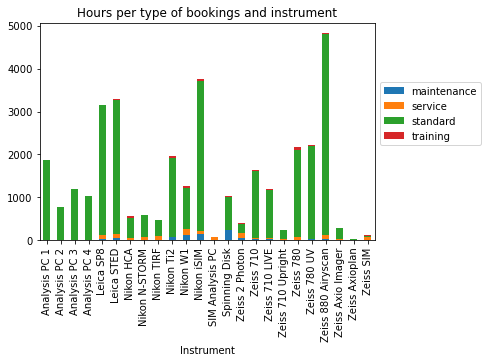

In [23]:
ti = bookings.groupby(['Type','Instrument'],as_index=False).agg(Hours=pd.NamedAgg(column="Hours", aggfunc="sum"),
                                        Count=pd.NamedAgg(column="Hours", aggfunc="count")).pivot('Instrument','Type','Hours')
ti.to_csv('booking-by-type-and-instrument.csv')

ti.plot(kind='bar',stacked=True)
plt.legend(bbox_to_anchor=(1,0.75))
plt.title('Hours per type of bookings and instrument')
plt.savefig('usage-per-type-per-instrument.pdf')


## Filter out bookings to eliminate unwanted entries

In [24]:
# excludes special bookings
bookings = bookings[ ~bookings['Type'].isin( remove_bookings_type ) ]
# excludes instruments
bookings = bookings[~bookings.Instrument.isin( remove_instrument )]
bookings.head()

,Subject,Location,Start,End,User,Instrument,Duration,Hours,Type,Group,Division
0,agata,NaN,2021-05-31 09:00:00,2021-05-31 17:00:00,Agata Nyga,Nikon W1,0 days 08:00:00,8.0,standard,Baum,Cell Biology
1,agata,NaN,2021-06-01 09:00:00,2021-06-01 18:00:00,Agata Nyga,Nikon W1,0 days 09:00:00,9.0,standard,Baum,Cell Biology
2,giulia,Nikon_W1_1N080,2021-06-02 10:00:00,2021-06-02 13:00:00,Giulia Cazzagon,Nikon W1,0 days 03:00:00,3.0,standard,Baum,Cell Biology
3,dan 2s409,Nikon_W1_1N080,2021-06-02 14:00:00,2021-06-02 17:00:00,Daniel Lloyd-Davies Sanchez,Nikon W1,0 days 03:00:00,3.0,standard,Lancaster,Cell Biology
4,dan,Nikon_W1_1N080,2021-06-03 10:30:00,2021-06-03 13:30:00,Daniel Lloyd-Davies Sanchez,Nikon W1,0 days 03:00:00,3.0,standard,Lancaster,Cell Biology


## Usage per groups

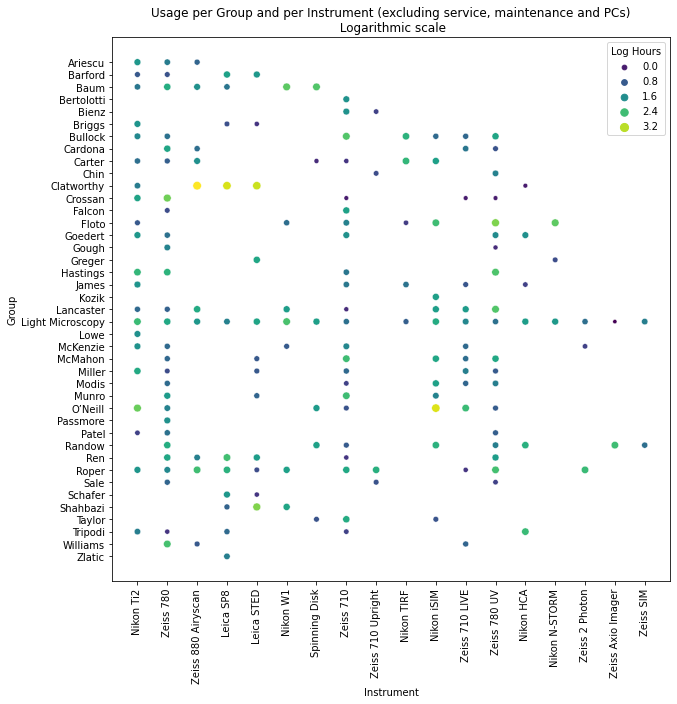

In [25]:
import math
bookings.groupby(['Group','Instrument'], as_index=False)['Hours'].agg('sum').pivot(index="Group",columns="Instrument",values='Hours').fillna(0).to_csv('usage-per-group-per-instrument.csv')
f,x = plt.subplots(figsize=(10,10))
tmp = bookings.groupby(['Group','Instrument'], as_index=False)['Hours'].agg('sum')
tmp['Hours'] = [math.log10(x) for x in tmp['Hours']]
cmap = sns.color_palette("viridis", as_cmap=True)
sns.scatterplot(data=tmp, x='Instrument', y='Group', size='Hours', hue='Hours',palette=cmap)
plt.xticks(rotation=90)
plt.title('Usage per Group and per Instrument (excluding service, maintenance and PCs)\n Logarithmic scale')
plt.legend(title="Log Hours")
plt.savefig('usage-per-group-per-instrument.pdf')


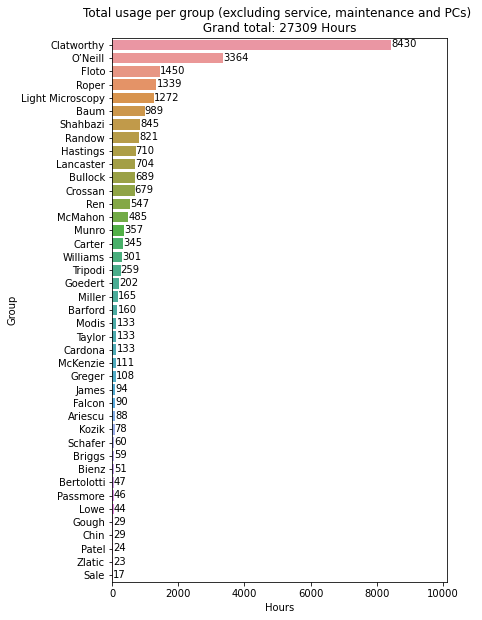

In [26]:
def show_values_on_bars(axs, h_v="v", space=0.4, hspace=0.5):
    """from https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values"""
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - p.get_height() * hspace
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

import numpy as np
total_usage_hrs = bookings['Hours'].sum()
df = bookings.groupby(['Group'],as_index=False).agg('sum')
grp_order = np.flip(df['Hours'].to_numpy().argsort())
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data=df,y='Group',x='Hours',order=df['Group'][grp_order])
show_values_on_bars(ax,'h',hspace=0.25)
plt.title(f'Total usage per group (excluding service, maintenance and PCs) \n Grand total: {total_usage_hrs:.0f} Hours ')
plt.xlim([0, 1.2*df['Hours'].max()])
plt.savefig('usage-per-group.pdf',pad_inches=1.2,bbox_inches='tight')

## Statistics per division

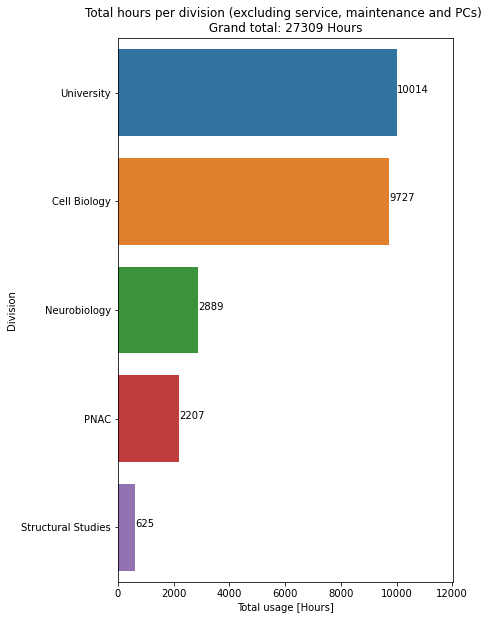

In [27]:
# Sum usage hours per division
per_division = bookings.groupby(['Division'],as_index=False)['Hours'].agg('sum')
grp_order = np.flip(per_division ['Hours'].to_numpy().argsort())
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data=per_division ,y='Division',x='Hours',order=per_division['Division'][grp_order])
show_values_on_bars(ax,'h')
total_usage_hrs = bookings['Hours'].sum()
plt.title(f'Total hours per division (excluding service, maintenance and PCs) \n Grand total: {total_usage_hrs:.0f} Hours ')
plt.xlim([0, 1.2*per_division['Hours'].max()])
plt.xlabel('Total usage [Hours]')
plt.savefig('usage-per-division.pdf',pad_inches=1.2,bbox_inches='tight')

## Compute Usage for each week and each instrument

In [28]:
usage = get_usage_by_instrument(bookings, start_date=start_date, num_weeks=num_weeks)

NameError: name 'daterange' is not defined

In [ ]:
sns.scatterplot(data=usage[usage['Usage']>0].sort_values('Instrument'),x='Week',y='Instrument',hue='Usage',size='Usage')
plt.legend(bbox_to_anchor=(1,0.7))
plt.title('Usage per week and per instrument (excluding service, maintenance and PCs)')
plt.savefig('usage-per-instrument-per-week-blot.pdf',pad_inches=1.2,bbox_inches='tight')

In [ ]:
import numpy as np
# figure for each instruments
col_order = [*usage['Instrument'].unique()]
col_order.sort()
g = sns.FacetGrid(usage, col="Instrument",col_wrap=4,col_order=col_order)
p = g.map(sns.barplot,"Week","Usage",order=np.arange(num_weeks))
averages = usage.groupby('Instrument')['Usage'].agg(['mean'])
avg_global = averages.mean()[0]
for k, a in enumerate(p.axes):        
    mic = a.get_title().replace('Instrument = ','')    
    avg = averages['mean'][mic]
    a.set_title(f'{mic} - average:{avg:.0f}h/w')
    a.axhline(avg_global, color='r', linestyle='-')    
    a.axhline(avg, color='g', linestyle='-')
    a.set_ylabel('Usage [Hours/Week]')
    a.set_xticks(np.arange(0,num_weeks,step=10))
    a.set_xticklabels(np.arange(0,num_weeks,step=10))
p.fig.subplots_adjust(top=0.9)
p.fig.suptitle('Usage per week and per instrument (excluding service, maintenance and PCs)')
plt.savefig('usage-per-instrument-per-week.pdf')


Save usage to a csv file

In [ ]:
# Save the data in a file
usage.pivot(index="Week",columns="Instrument",values="Usage").to_csv('usage-per-instrument-per-week.csv')